In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import eddington
data = pd.read_excel('AHE - 24.xlsx')
plt.rcParams['figure.figsize'] = [20,10]

In [2]:
# plt.plot(data['H [Gauss]'],data['R [kOhm]'])
# plt.show()
# plt.plot(data.index,data['R [kOhm]'])
# plt.show()

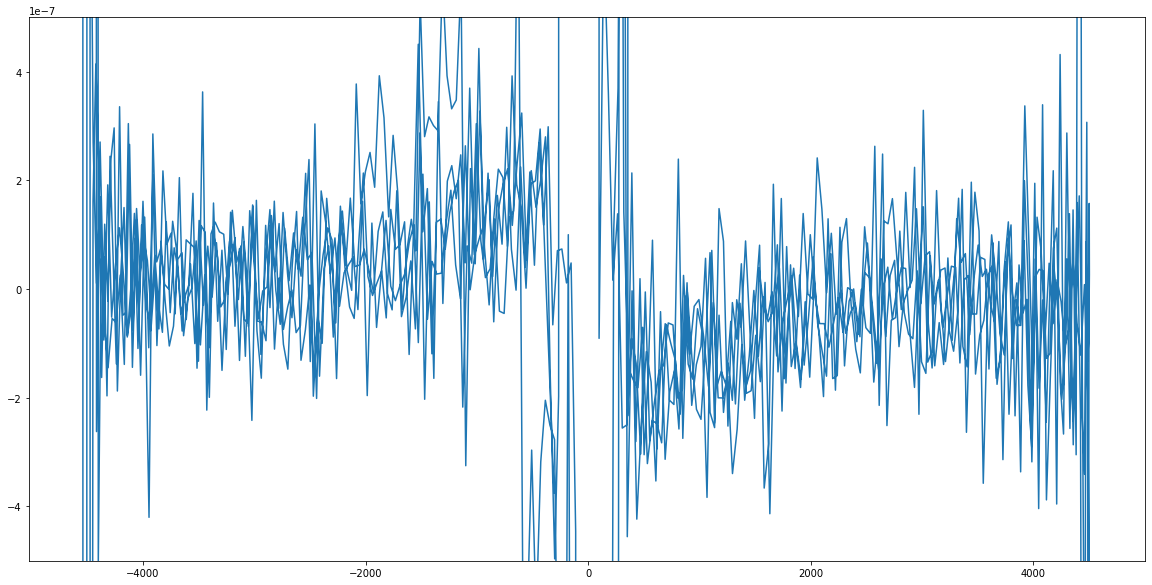

In [3]:
data['Derivative [kOhm/Gauss]'] = [np.nan]*2 + [(data['R [kOhm]'][i+2]-2*data['R [kOhm]'][i+1]+data['R [kOhm]'][i])/(((data['H [Gauss]'][i+1]-data['H [Gauss]'][i]))**2) for i in range(len(data['R [kOhm]'])-2)]
wind = 10
plt.plot(data['H [Gauss]'].rolling(wind).mean(),data['Derivative [kOhm/Gauss]'].rolling(wind).mean())
plt.ylim([-0.0000005, 0.0000005])
plt.show()

In [2]:
def inn(x,lst):
    return (x < lst[1]) and (x>lst[0])

def findRegions(x,y,regions):
    Regs = []
    indices = [0,0]
    for j in range(len(regions)):
        reg = np.array([inn(x[i],regions[j])*np.sign(x[i+1]-x[i]) for i in range(len(x)-1)], dtype=int)
        i=0
        temp = []
        if reg[0]!=0:
            while i < len(reg)-1 and reg[i]!=reg[i+1]:
                i+=1
            temp.append([0,i,reg[0], j])
        
        while i < len(reg)-1:
            if reg[i]!=reg[i+1]:
                if indices == [0,0]:
                    indices[0] = i
                else:
                    indices[1] = i
                    if reg[i]:
                        temp.append(indices + [reg[i], j])
                    
                    if reg[i+1]:
                        indices = [i+1,0]
                    else:
                        indices=[0,0]
            i+=1
        Regs.append(temp)
    
    return np.array(Regs)

def Edwardo(x,y,region,dx=0.001,dy=0.001):
    region = [int(reg) for reg in region]
    data = eddington.FittingData(dict(x = x[region[0]:region[1]], dx = np.zeros_like(x[region[0]:region[1]]) + dx,\
                                      y = y[region[0]:region[1]], dy = np.zeros_like(y[region[0]:region[1]]) + dy))
    fit = eddington.fit(data,eddington.linear)
    return fit.a

In [4]:
x = data['H [Gauss]'] 
y = data['R [kOhm]'] 
regionsLR = np.array([[-5000,-3000], [-2500,-1500], [1500,2500], [3000,5000]]) #Left, C-Left, C-Right, Right
LR = findRegions(x,y,regionsLR)
ZR = findRegions(x,y,np.array([[-5000,-200],[200,5000]]))
ZR = np.array(sorted(np.vstack((ZR[0],ZR[1])), key=lambda x: x[0]))

In [5]:
LR

array([[[311, 352,  -1,   0],
        [353, 400,   1,   0],
        [789, 833,  -1,   0],
        [834, 885,   1,   0]],

       [[274, 298,  -1,   1],
        [413, 437,   1,   1],
        [751, 776,  -1,   1],
        [898, 922,   1,   1]],

       [[ 36,  60,   1,   2],
        [176, 199,  -1,   2],
        [511, 535,   1,   2],
        [653, 678,  -1,   2]],

       [[ 73, 116,   1,   3],
        [117, 163,  -1,   3],
        [548, 591,   1,   3],
        [592, 641,  -1,   3]]])

In [6]:
tracks = np.full(2*len(regionsLR)+1,np.nan)
solr=np.array(sorted(np.vstack(LR), key= lambda x: x[0]), dtype=int).T
i=0
while solr[2,i]==solr[2,i+1]:
    tracks[2*solr[3,i]]=solr[0,i]
    tracks[2*solr[3,i]+1]=solr[1,i]
    i+=1
tracks[2*solr[3,i]]=solr[0,i]
tracks[2*solr[3,i]+1]=solr[1,i]
tracks[-1]=solr[2][i]
i+=1

while i<len(solr[2]):
    temp = np.full(2*len(regionsLR)+1,np.nan)
    while i<len(solr[2])-1 and solr[2,i]==solr[2,i+1]:
        temp[2*solr[3,i]]=solr[0,i]
        temp[2*solr[3,i]+1]=solr[1,i]
        i+=1
    temp[2*solr[3,i]]=solr[0,i]
    temp[2*solr[3,i]+1]=solr[1,i]
    temp[-1]=int(solr[2][i])
    tracks = np.vstack((tracks,temp))
    i+=1
tracks

array([[ nan,  nan,  nan,  nan,  36.,  60.,  73., 116.,   1.],
       [311., 352., 274., 298., 176., 199., 117., 163.,  -1.],
       [353., 400., 413., 437., 511., 535., 548., 591.,   1.],
       [789., 833., 751., 776., 653., 678., 592., 641.,  -1.],
       [834., 885., 898., 922.,  nan,  nan,  nan,  nan,   1.]])

In [7]:
x = data['H [Gauss]'].to_numpy()
y = data['R [kOhm]'].to_numpy()
fits = [[[np.nan,np.nan]]*len(regionsLR)]
i=2
while i*2<len(tracks[0])-1:
    fits[0][i] = Edwardo(x,y,tracks[0][i*2:(i+1)*2])
    i+=1
    
for track in tracks[1:-1]:
    temp = [[np.nan,np.nan]]*len(regionsLR)
    i=0
    while i*2<len(track)-1:
        temp[i] = Edwardo(x,y,track[i*2:(i+1)*2])
        i+=1
    fits.append(temp)

temp = [[np.nan,np.nan]]*len(regionsLR)
i=0
while not np.isnan(tracks[-1][i*2]):
    temp[i] = Edwardo(x,y,track[i*2:(i+1)*2])
    i+=1
fits.append(temp)
fits = np.array(fits)
fits

array([[[           nan,            nan],
        [           nan,            nan],
        [2.11258285e+01, 8.53213733e-05],
        [2.12520453e+01, 3.70961354e-05]],

       [[2.06462327e+01, 3.95967071e-05],
        [2.07727105e+01, 8.72896479e-05],
        [2.11137171e+01, 8.64830239e-05],
        [2.12457979e+01, 3.78172794e-05]],

       [[2.06453208e+01, 3.89279444e-05],
        [2.07759609e+01, 8.67542964e-05],
        [2.11441254e+01, 8.14312040e-05],
        [2.12651808e+01, 3.50667469e-05]],

       [[2.06418597e+01, 4.01862127e-05],
        [2.07706783e+01, 8.91485588e-05],
        [2.11292043e+01, 8.32888834e-05],
        [2.12491169e+01, 3.84986820e-05]],

       [[2.06418597e+01, 4.01862127e-05],
        [2.07706783e+01, 8.91485588e-05],
        [           nan,            nan],
        [           nan,            nan]]])

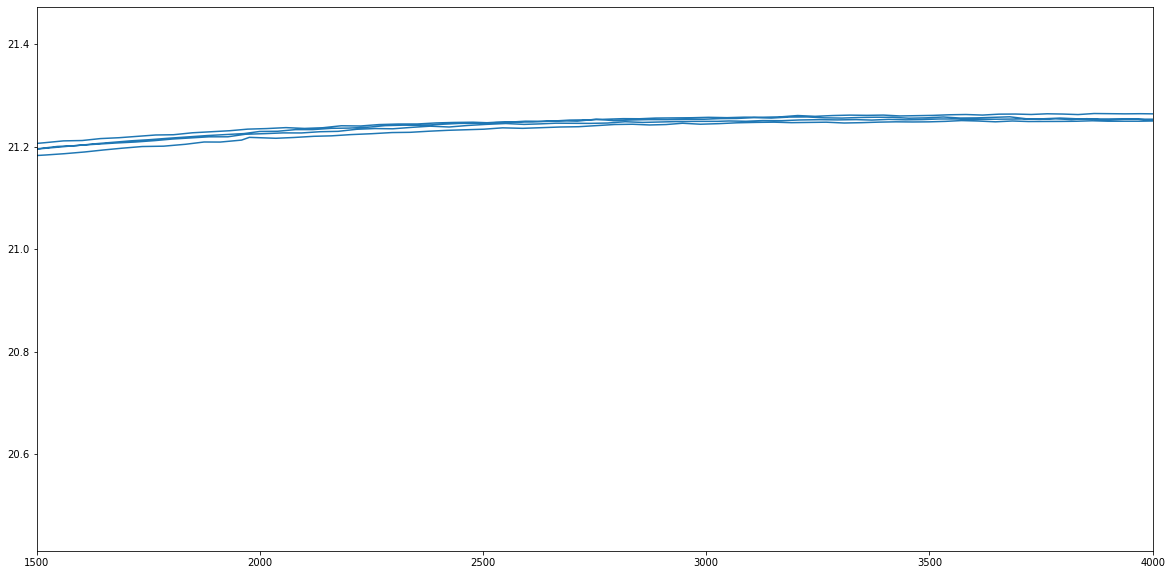

In [19]:
x = data['H [Gauss]'].to_numpy()
y = data['R [kOhm]'].to_numpy()
fits = [[[np.nan,np.nan]]*len(regionsLR)]
i=2
while i*2<len(tracks[0])-1:
    fits[0][i] = Edwardo(x,y,tracks[0][i*2:(i+1)*2])
    i+=1
    
for track in tracks[1:-1]:
    temp = [[np.nan,np.nan]]*len(regionsLR)
    i=0
    while i*2<len(track)-1:
        temp[i] = Edwardo(x,y,track[i*2:(i+1)*2])
        i+=1
    fits.append(temp)

temp = [[np.nan,np.nan]]*len(regionsLR)
i=0
while not np.isnan(tracks[-1][i*2]):
    temp[i] = Edwardo(x,y,track[i*2:(i+1)*2])
    i+=1
fits.append(temp)
fits = np.array(fits)
fits

# x = np.copy(data['H [Gauss]'].to_numpy())
# y = np.copy(data['R [kOhm]'].to_numpy())

def noNanMinMax(track):
    noNan = track[:-1][~np.isnan(track[:-1])]
    return int(min(noNan)), int(max(noNan))

minn, maxx = noNanMinMax(tracks[0])
minn = 0
y[minn:maxx][x[minn:maxx]>0] = y[minn:maxx][x[minn:maxx]>0]-x[minn:maxx][x[minn:maxx]>0]*fits[0,3,1]

for i in range(len(tracks)-2):
    minn, maxx = noNanMinMax(tracks[1:-1][i])
    if len(y[minn:maxx][x[minn:maxx]<-200]):
        y[minn:maxx][x[minn:maxx]<0] = y[minn:maxx][x[minn:maxx]<0]-x[minn:maxx][x[minn:maxx]<0]*fits[i,0,1]
    if len(y[minn:maxx][x[minn:maxx]>200]):
        y[minn:maxx][x[minn:maxx]>0] = y[minn:maxx][x[minn:maxx]>0]-x[minn:maxx][x[minn:maxx]>0]*fits[i,3,1]

minn, maxx = noNanMinMax(tracks[-1])
maxx = len(y)-1
y[minn:maxx][x[minn:maxx]<0] = y[minn:maxx][x[minn:maxx]<0]-x[minn:maxx][x[minn:maxx]<0]*fits[-1,0,1]

plt.plot(x,y)
plt.xlim([1500,4000])
plt.show()

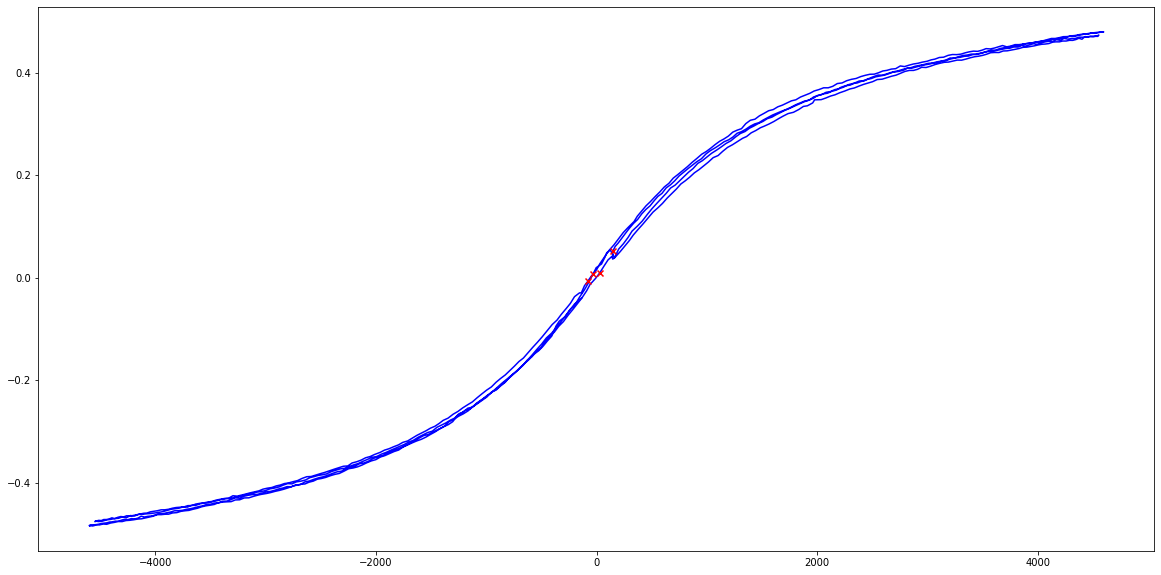

[147.15, 31.59, -80.32, -28.966] 72.0065


In [9]:
x = np.copy(data['H [Gauss]'].to_numpy())
y = np.copy(data['R [kOhm]'].to_numpy())
y = y-sum(y)/len(y)
ZR = [1]
i=0
while i<len(x)-1:
    if y[i]*y[i+1]<=0:
        ZR.append(i)
    i+=1
ZRx = [x[j] for j in ZR]
ZRy = [y[j] for j in ZR]
plt.plot(x,y,c='b', zorder=1)
plt.scatter(ZRx,ZRy,c='r',marker='x', zorder=2)
plt.show()
print(ZRx, sum(np.abs(ZRx))/len(ZRx))

# DONT RUN THE NEXT BLOCKS, ITS THE OLD CODE

In [10]:
def RtoL(region,data,i,direction):
    lst = []
    while i<(len(data['R [kOhm]'])-4) \
    and direction*(data['H [Gauss]'][i+4]-data['H [Gauss]'][i]) > 0 \
    and inn(data['H [Gauss]'][i],region):
        i+=1
        lst.append([data['H [Gauss]'][i],data['R [kOhm]'][i]])
    lst = np.array(lst).T
    lst = eddington.FittingData(dict(x = lst[0], dx = np.zeros_like(lst[0]) + 0.03,\
                                               y = lst[1], dy = np.zeros_like(lst[1]) + 0.003))
    return lst, i
i = 0
center_right = [1500,2500]
center_left = [-2500,-1500]
right = [3000,5000]
left = [-5000,-3000]
data['R [kOhm]'] -= data['R [kOhm]'].mean()
data['no hall'] = data['R [kOhm]']
lefti = 0
righti = 0
zero = 0

fits = []

while i<len(data['R [kOhm]']):
    if i+4<len(data['R [kOhm]']):
        direction = 2*((data['H [Gauss]'][i+4]-data['H [Gauss]'][i]) > 0)-1 # 1 for right -> left, -1 otherwise
    fit = [np.nan, np.nan, np.nan, np.nan, direction]
    
    if direction + 1:
        if inn(data['H [Gauss]'][i],left):
            lefti = i
            fitt_data, i = RtoL(left,data,i,direction)
            fit[0] = eddington.fit(fitt_data,eddington.linear)
            
        
        if data['H [Gauss]'][i] < center_left[0] or inn(data['H [Gauss]'][i],center_left):
            while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],center_left):
                i+=1

        if i+4>=len(data['R [kOhm]']):
            fits.append(fit)
            print('Hello1')
            if isinstance(fit[0],eddington.fitting_result.FittingResult):
                        data['no hall'][lefti:]=data['no hall'][lefti:] - data['H [Gauss]'][lefti:]*fit[0].a[1]
            break
        if inn(data['H [Gauss]'][i],center_left):
            fitt_data, i = RtoL(center_left,data,i,direction)
            fit[1] = eddington.fit(fitt_data,eddington.linear)
            
        if data['H [Gauss]'][i] < center_right[0] or inn(data['H [Gauss]'][i],center_right):
            while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],center_right):
                if i+1<len(data['R [kOhm]']) and (data['H [Gauss]'][i] < 0 and data['H [Gauss]'][i+1] >=0):
                    zero = i+1
                    if isinstance(fit[0],eddington.fitting_result.FittingResult):
                        minn = min(zero,lefti)
                        maxx = max(zero,lefti)
                        data['no hall'][minn:maxx]=data['no hall'][minn:maxx] - data['H [Gauss]'][minn:maxx]*fit[0].a[1]
                i+=1
        if i+4>=len(data['R [kOhm]']):
            fits.append(fit)
            if isinstance(fit[0],eddington.fitting_result.FittingResult):
                    data['no hall'][lefti:]=data['no hall'][lefti:] - data['H [Gauss]'][lefti:]*fit[0].a[1]
            break
        fitt_data, i = RtoL(center_right,data,i,direction)
        fit[2] = eddington.fit(fitt_data,eddington.linear)
        while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],right):
            i+=1
        
        if i+4>=len(data['R [kOhm]']):
            fits.append(fit)
            break
        fitt_data, i = RtoL(right,data,i,direction)
        righti = i
        fit[3] = eddington.fit(fitt_data,eddington.linear)
        data['no hall'][zero:righti]=data['no hall'][zero:righti] - data['H [Gauss]'][zero:righti]*fit[3].a[1]
        
    if direction-1:
        if inn(data['H [Gauss]'][i],right):
            righti = i
            fitt_data, i = RtoL(right,data,i,direction)
            fit[3] = eddington.fit(fitt_data,eddington.linear)
            
        if data['H [Gauss]'][i] > center_right[1] or inn(data['H [Gauss]'][i],center_right):
            while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],center_right):
                i+=1

            if i+4>=len(data['R [kOhm]']):
                fits.append(fit)
                break
            
            fitt_data, i = RtoL(center_right,data,i,direction)
            fit[2] = eddington.fit(fitt_data,eddington.linear)
            
        if data['H [Gauss]'][i] > center_left[1] or inn(data['H [Gauss]'][i],center_left):
            while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],center_left):
                if i+1<len(data['R [kOhm]']) and (data['H [Gauss]'][i] > 0 and data['H [Gauss]'][i+1] <=0):
                    zero = i+1
                    if isinstance(fit[3],eddington.fitting_result.FittingResult):
                        minn = min(zero,righti)
                        maxx = max(zero,righti)
                        data['no hall'][minn:maxx]=data['no hall'][minn:maxx] - data['H [Gauss]'][minn:maxx]*fit[3].a[1]
                i+=1

        if i+4>=len(data['R [kOhm]']):
            fits.append(fit)
            break
        fitt_data, i = RtoL(center_left,data,i,direction)
        fit[1] = eddington.fit(fitt_data,eddington.linear)

        while i<len(data['R [kOhm]']) and not inn(data['H [Gauss]'][i],left):
            i+=1

        if i+4>=len(data['R [kOhm]']):
            fits.append(fit)
            break
        fitt_data, i = RtoL(left,data,i,direction)
        minn = min(zero,i)
        maxx = max(zero,i)
        fit[0] = eddington.fit(fitt_data,eddington.linear)
        data['no hall'][minn:maxx]=data['no hall'][minn:maxx] - data['H [Gauss]'][minn:maxx]*fit[0].a[1]
    
    
    fits.append(fit)
    fitt_data = []
    i+=1
fits = np.array(fits)

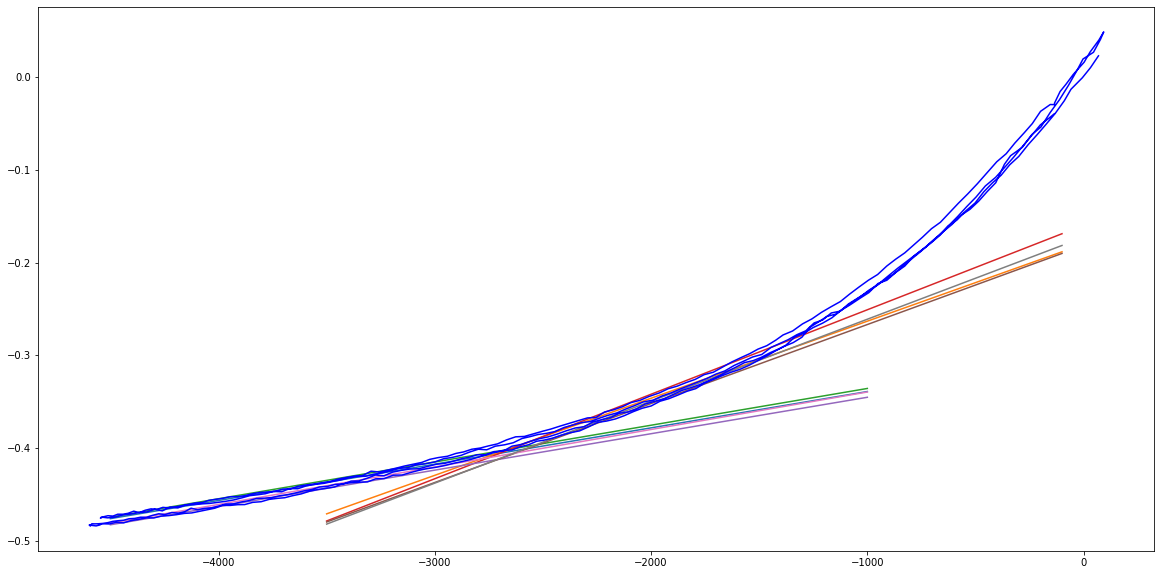

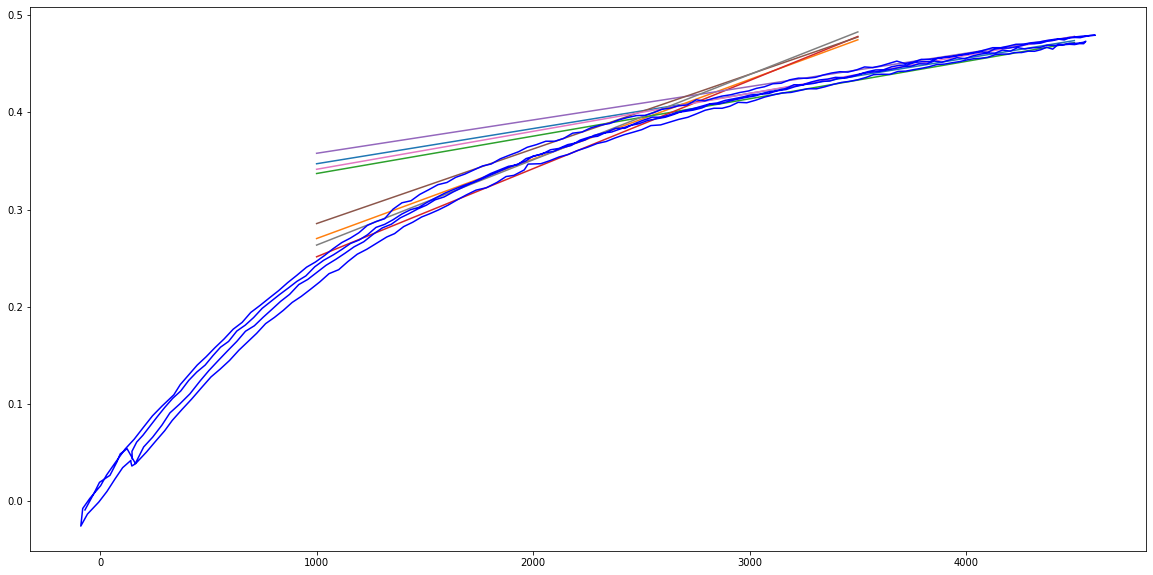

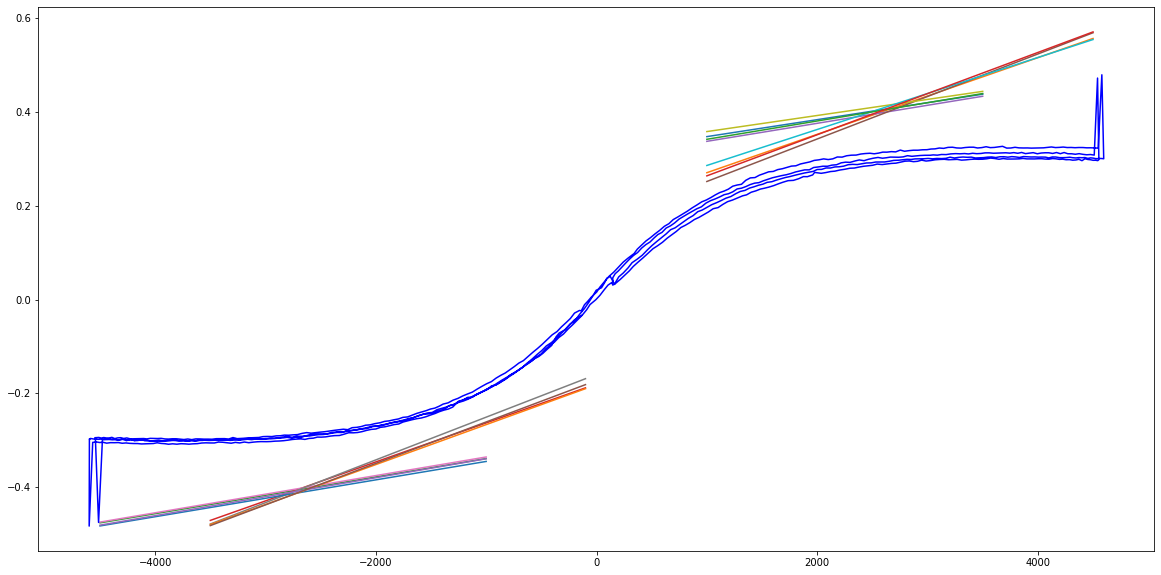

In [11]:
for fit in fits:
    if fit[0] is not np.nan:
        x = np.linspace(-4500,-1000,num=200)
        plt.plot(x,fit[0].a[0]+fit[0].a[1]*x)
    if fit[1] is not np.nan:
        x = np.linspace(-3500,-100,num=200)
        plt.plot(x,fit[1].a[0]+fit[1].a[1]*x)
plt.plot(data['H [Gauss]'][data['H [Gauss]']<100],data['R [kOhm]'][data['H [Gauss]']<100], c='b')
plt.show()

for fit in fits:
    if fit[3] is not np.nan:
        x = np.linspace(1000,4500,num=200)
        plt.plot(x,fit[3].a[0]+fit[3].a[1]*x)
    if fit[2] is not np.nan:
        x = np.linspace(1000,3500,num=200)
        plt.plot(x,fit[2].a[0]+fit[2].a[1]*x)
plt.plot(data['H [Gauss]'][data['H [Gauss]']>-100],data['R [kOhm]'][data['H [Gauss]']>-100], c='b')
plt.show()

for fit in fits:
    if fit[0] is not np.nan:
        x = np.linspace(-4500,-1000,num=200)
        plt.plot(x,fit[0].a[0]+fit[0].a[1]*x)
    if fit[1] is not np.nan:
        x = np.linspace(-3500,-100,num=200)
        plt.plot(x,fit[1].a[0]+fit[1].a[1]*x)
    if fit[2] is not np.nan:
        x = np.linspace(1000,3500,num=200)
        plt.plot(x,fit[3].a[0]+fit[3].a[1]*x)
    if fit[3] is not np.nan:
        x = np.linspace(1000,4500,num=200)
        plt.plot(x,fit[2].a[0]+fit[2].a[1]*x)
plt.plot(data['H [Gauss]'],data['no hall'], c='b')
plt.show()

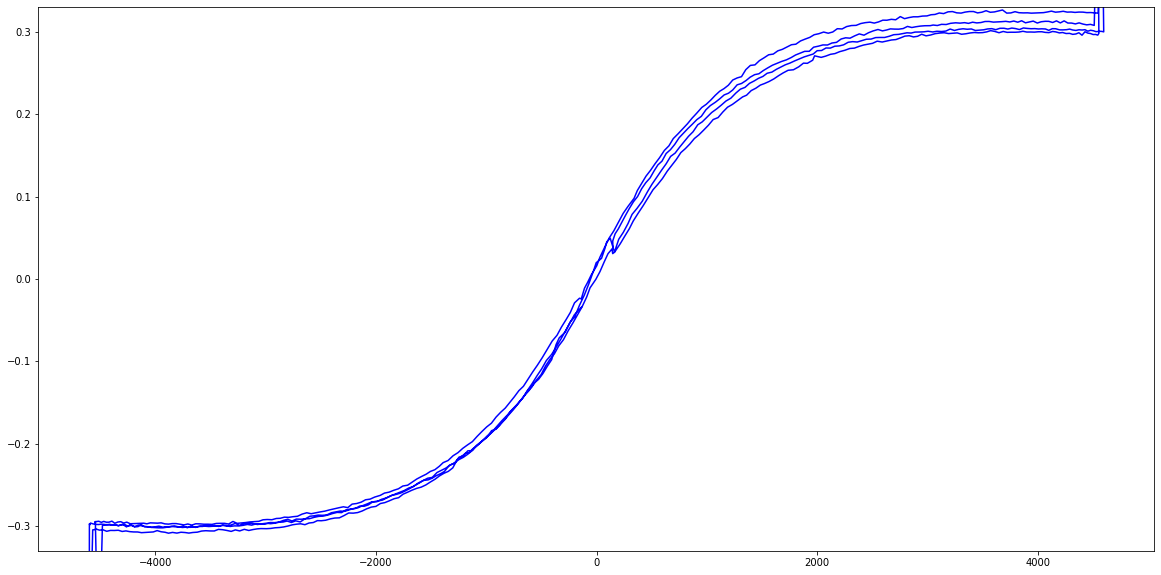

In [12]:
plt.plot(data['H [Gauss]'],data['no hall'], c='b')
plt.ylim([-0.33,0.33])
plt.show()

In [13]:
def slope(slp):
    if slp is not np.nan:
        return slp.a
    return np.array([np.nan,np.nan])

slopes = np.array([[slope(slp) for slp in fit[:-1]] for fit in fits])

def intersection(a1,a2):
    if np.isnan(np.sum(np.hstack((a1,a2)))):
        return [np.nan, np.nan]
    return [(a1[0]-a2[0])/(a2[1]-a1[1]), a2[1]*(a1[0]-a2[0])/(a2[1]-a1[1]) + a2[0]]\

sat = []
for slps in slopes:
    sat.append(intersection(slps[0],slps[1]))
    sat.append(intersection(slps[2],slps[3]))
sat = np.array(sat).T
sat = np.abs(sat[:,~np.isnan(sat).any(axis=0)])
sum(sat[1])/len(sat[1])
mag = []
hall = []
for slp in slopes:
    if not np.isnan(sum(slp.flatten())):
        mag = np.hstack((mag,[slp[0][0],slp[3][0]]))
        hall = np.hstack((hall,[slp[0][1],slp[3][1]]))
mag = np.abs(mag)
mag

array([0.29993353, 0.29879739, 0.29612787, 0.3237554 , 0.30600593,
       0.3025792 ])

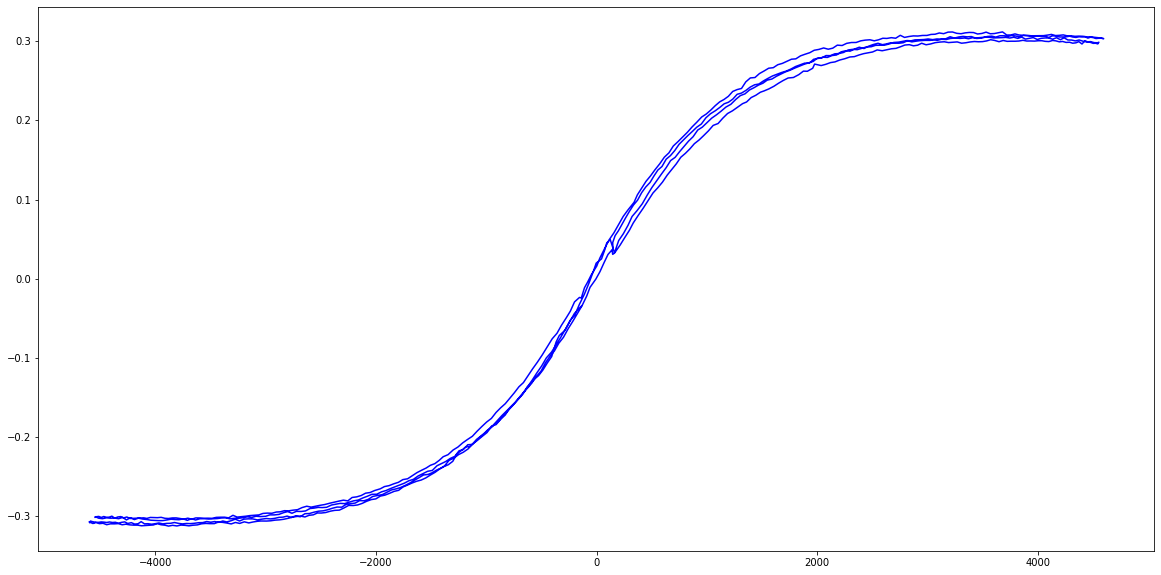

In [14]:
plt.plot(data['H [Gauss]'],data['R [kOhm]']-sum(hall)/len(hall)*data['H [Gauss]'], c='b')
plt.show()